In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
import cv2
from PIL import Image

from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

In [6]:
image_directory = '/kaggle/input/human-detection-data/human_data/'

In [7]:
SIZE = 150
dataset = []
label = []

In [8]:
# for images not containing humans
images_without_humans = os.listdir(image_directory + '0/')
for i, image_name in enumerate(images_without_humans):
    if(image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + '0/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [9]:
# for images containing humans
images_with_humans = os.listdir(image_directory + '1/')
for i, image_name in enumerate(images_with_humans):
    if(image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + '1/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

In [10]:
dataset = np.array(dataset)
label = np.array(label)
print("Shape of image dataset: ", dataset.shape)
print("Shape of labels: ", label.shape)

Shape of image dataset:  (921, 150, 150, 3)
Shape of labels:  (921,)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)

In [12]:
# normalizing
X_train = X_train / 255
X_test = X_test / 255

In [13]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [39]:
def create_model(base_model):
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(base_model.inputs, outputs)
    
    return model 

In [60]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    
    early = tf.keras.callbacks.EarlyStopping( patience = 5,
                                              min_delta = 0.01,
                                              restore_best_weights = True)
    
    print("Unfreezing number of layers in base model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(2*1e-4),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        validation_data = (X_test, Y_test),
                        epochs = 15,
                        callbacks = [early])
    
    return history

#### Fine-tuned Inception model:

In [41]:
# load the InceptionResNetV2 architecture with imagenet weights as base
inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (150, 150, 3)
                     )

In [61]:
inception_model = create_model(inception_base_model)
inception_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_609 (Conv2D)            (None, 74, 74, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_609 (Batch  (None, 74, 74, 32)  96          ['conv2d_609[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [62]:
history = fit_model(inception_model, inception_base_model, epochs = 15)

Unfreezing number of layers in base model =  0
Epoch 1/15
23/23 [==============================] - 17s 292ms/step - loss: 0.2531 - accuracy: 0.8859 - val_loss: 0.3123 - val_accuracy: 0.9027
Epoch 2/15
23/23 [==============================] - 2s 88ms/step - loss: 0.0774 - accuracy: 0.9755 - val_loss: 0.3769 - val_accuracy: 0.8757
Epoch 3/15
23/23 [==============================] - 2s 85ms/step - loss: 0.0703 - accuracy: 0.9810 - val_loss: 0.3519 - val_accuracy: 0.8757
Epoch 4/15
23/23 [==============================] - 2s 73ms/step - loss: 0.0613 - accuracy: 0.9851 - val_loss: 0.3935 - val_accuracy: 0.8811
Epoch 5/15
23/23 [==============================] - 2s 85ms/step - loss: 0.0491 - accuracy: 0.9810 - val_loss: 0.4459 - val_accuracy: 0.8703
Epoch 6/15
23/23 [==============================] - 2s 91ms/step - loss: 0.0676 - accuracy: 0.9796 - val_loss: 0.3696 - val_accuracy: 0.8865


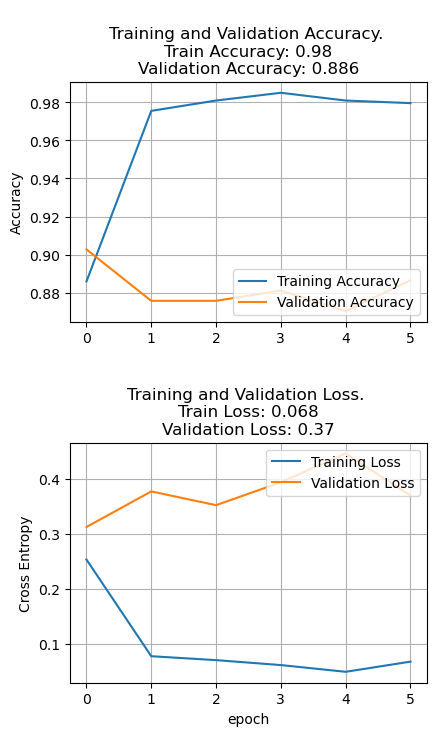

In [63]:
plot_history(history)

In [64]:
_, acc = inception_model.evaluate(X_test, Y_test)
print("Accuracy: ", (acc*100.0), " %")

6/6 [==============================] - 0s 65ms/step - loss: 0.3123 - accuracy: 0.9027
Accuracy:  90.27026891708374  %


In [65]:
# for fine-tuning the model
nr_base_layers = len(inception_base_model.layers)
print("Inception base layers = ", nr_base_layers)    

history = fit_model(inception_model, inception_base_model, epochs = 15, fine_tune = int(nr_base_layers/4))

Inception base layers =  780
Unfreezing number of layers in base model =  195
Epoch 1/15
23/23 [==============================] - 37s 297ms/step - loss: 0.1286 - accuracy: 0.9552 - val_loss: 1.1167 - val_accuracy: 0.8703
Epoch 2/15
23/23 [==============================] - 3s 128ms/step - loss: 0.1047 - accuracy: 0.9755 - val_loss: 0.9909 - val_accuracy: 0.8541
Epoch 3/15
23/23 [==============================] - 2s 98ms/step - loss: 0.0428 - accuracy: 0.9878 - val_loss: 0.9972 - val_accuracy: 0.8649
Epoch 4/15
23/23 [==============================] - 3s 116ms/step - loss: 0.0205 - accuracy: 0.9932 - val_loss: 0.8627 - val_accuracy: 0.8649
Epoch 5/15
23/23 [==============================] - 2s 100ms/step - loss: 0.0114 - accuracy: 0.9959 - val_loss: 0.9380 - val_accuracy: 0.8919
Epoch 6/15
23/23 [==============================] - 3s 119ms/step - loss: 0.0212 - accuracy: 0.9959 - val_loss: 0.8206 - val_accuracy: 0.8757
Epoch 7/15
23/23 [==============================] - 3s 114ms/step - lo

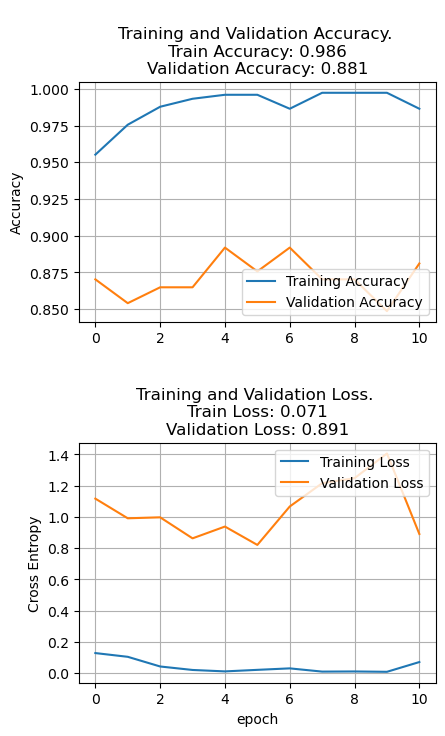

In [66]:
plot_history(history)

In [67]:
_, acc = inception_model.evaluate(X_test, Y_test)
print("Accuracy: ", (acc*100.0), " %")

6/6 [==============================] - 0s 61ms/step - loss: 0.8206 - accuracy: 0.8757
Accuracy:  87.56756782531738  %
